#### Task 1.2: Data Preparation

Improve the quality of your data and prepare it by extracting new features interesting for describing the incidents. Some examples of indicators to be computed are:

- How many males are involved in incidents relative to the total number of males for the same city and in the same period?
- How many injured and killed people have been involved relative to the total injured and killed people in the same congressional district in a given period of time?
- Ratio of the number of killed people in the incidents relative to the number of participants in the incident
- Ratio of unharmed people in the incidents relative to the average of unharmed people in the same period

Note that these examples are not mandatory, and teams can define their own indicators. Each indicator must be correlated with a description and, when necessary, its mathematical formulation. The extracted variables will be useful for the clustering analysis in the second project's task. Once the set of indicators is computed, the team should explore the new features for a statistical analysis, including distributions, outliers, visualizations, and correlations.

For task 1.1 see the corresponding Notebook in [Task 1.1 - Data Understanding](Task1_Data_Understanding.ipynb).

For this task we followed the following check structure: [#WIP]()
1. Data aggregation
2. Reduction of dimensionality
3. Data cleaning
4. Discretization
5. Data transformation
6. Principal Component Analysis via Covariance Matrix
8. Data Similarity via Entropy and proximity coefficients


In [1]:
# This will take a while
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import plotly.offline as py

# for dataset visibility
pd.set_option('display.max_columns', None)

# Set a seed for reproducibility
np.random.seed(42)

# Load dataset from data understanding
#df_incident_du = pd.read_csv('../ds/cleaned/incidents_cleaned.csv')
df = pd.read_hdf('../ds/cleaned/incidents_cleaned.h5', key = 'df')
df_incident_du = df.copy()   
df_poverty_du = pd.read_csv('../ds/cleaned/poverty_cleaned.csv')
df_years_state_du = pd.read_csv('../ds/cleaned/year_state_votes_cleaned.csv')


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.1
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# Check if dataset loaded correctly
#df_incident_du.head()
#df_poverty_du.head()
df_years_state_du.head()

#df_incident_du.info()

year    state  congressional_district       party  candidatevotes  \
0  2014  Alabama                       1  REPUBLICAN          103758   
1  2014  Alabama                       2  REPUBLICAN          113103   
2  2014  Alabama                       3  REPUBLICAN          103558   
3  2014  Alabama                       4  REPUBLICAN          132831   
4  2014  Alabama                       5  REPUBLICAN          115338   

   totalvotes  
0      152234  
1      167952  
2      156620  
3      134752  
4      154974

### Fix little problem with reimporting datasets

CSV files do not store informations about categories and datatypes like the one we saved.

# Joining the datasets

We have three dataset: the one with the incidents, one with poverty by state (just two columns) and one with year, state and how much votes each party got. We want to join the three datasets in order to have a single dataset with all the information we need. 

In [3]:
# We need to do merge function from pandas

df_merged_incident_poverty = pd.merge(df_incident_du ,df_poverty_du, on=['year', 'state'], how='left')

# This produces nans on 70k party columns...
#df_merged_incident_votes = pd.merge(df_merged_incident_poverty ,df_years_state_du, on=['year', 'state', 'congressional_district'], how='left')

df_merged_incident_poverty.head()

#df_merged_incident_votes.head()

df_merged = df_merged_incident_poverty.copy()
# now merge the two merged
#df_merged = pd.merge(df_merged_incident_votes ,df_poverty_du, on=['year', 'state'], how='left')

#df_merged.head()


## Definition of indexes


1. Ratio of the number of the killed people in the incident w.r.t. the number of participants in the incident

How we can see the majority of the incidents have a ratio of 0 and there are not a lot of different ration, they are just 7,
we could try to discretize this feature in order to have a better visualization. By making this a categorical feature we can see that the majority of the incidents have a ratio of 0 and there are not a lot of different ration, they are just 7.

Let's visualize it with a barplot.

In [4]:

# divide for each incident n_killed by n_participants
df_merged['n_killed_per_participant'] = df_merged['n_killed'] / df_merged['n_participants']


In [5]:

# groupby different value of n_killed_per_participant
print(df_merged.groupby('n_killed_per_participant').size())

n_killed_per_participant
0.000000    92428
0.250000     1830
0.333333     4667
0.500000    15855
0.666667      861
0.750000      136
1.000000    18802
dtype: int64


## Discritization of the ratio

Let's discretize these values into 3 main categories since we have a lot of incidents with ratio being 0 and this is first category: let's call it: **"No deaths"**, these can be those were someone just shot in the air or something like this, we could do more by using the **incidents_charactetistics1** and see what type of those is the majority.

Then we have some of incidents with ratio from 0.25, 0.33, 0.5 (that is the majority), 0.66 and 0.75 and this is second category, so incidents where someone died but not all the people involved in the incident: let's call it: **"Some deaths"**.

Then we have another category with lots of incidents with ratio being 1 and this is third category: **"All deaths"**.

<AxesSubplot:ylabel='n_killed_per_participant'>

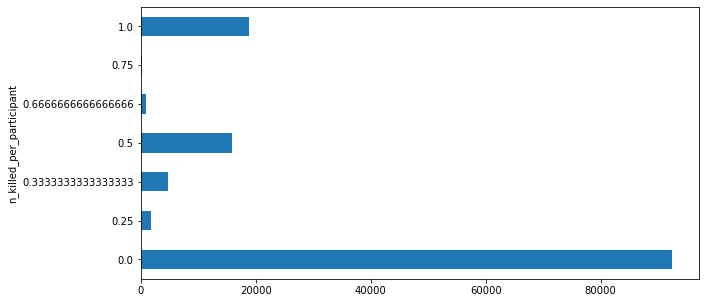

In [6]:
# Barplot of n_killed_per_participant and number of incidents using our groupby rotated along the y axis
df_merged.groupby('n_killed_per_participant').size().plot(kind='barh', figsize=(10, 5), rot=0)

#df_merged.groupby('n_killed_per_participant').size().plot(kind='bar', figsize=(10, 5), rot=0)

In [7]:
# Discretize by gathering the n_killed_per_participants into 3 categories as we discussed
# If ration is [0,0.1), then label is 'No deaths', if ratio is [0.1, 0.75), then label is 'Some deaths', if ratio is [0.75, 1], then label is 'All deaths'

ratios = {'No deaths': [0, 0.1], 'Some deaths': [0.1, 0.75], 'All deaths': [0.75, 1]}

# map to n_killed_per_participant

df_merged['n_killed_per_participant'] = df_merged['n_killed_per_participant'].map(
    lambda x: 'No deaths' if x >= ratios['No deaths'][0] and x < ratios['No deaths'][1] else 
    ('Some deaths' if x >= ratios['Some deaths'][0] and x < ratios['Some deaths'][1] else 'All deaths'))


/tmp/ipykernel_108789/967519922.py:8: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



<AxesSubplot:ylabel='n_killed_per_participant'>

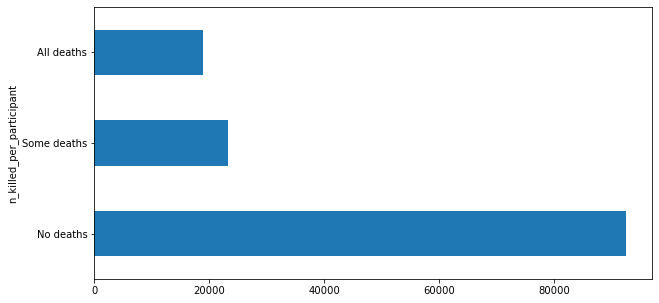

In [8]:
#df_merged.head()
# order the categories from 'No deaths' to 'All deaths'
df_merged['n_killed_per_participant'] = pd.Categorical(df_merged['n_killed_per_participant'], 
                                                       categories=['No deaths', 'Some deaths', 'All deaths'], 
                                                       ordered=True)

# Barplot after discretization
df_merged.groupby('n_killed_per_participant').size().plot(kind='barh', figsize=(10, 5), rot=0)

## Correlation matrix on new data

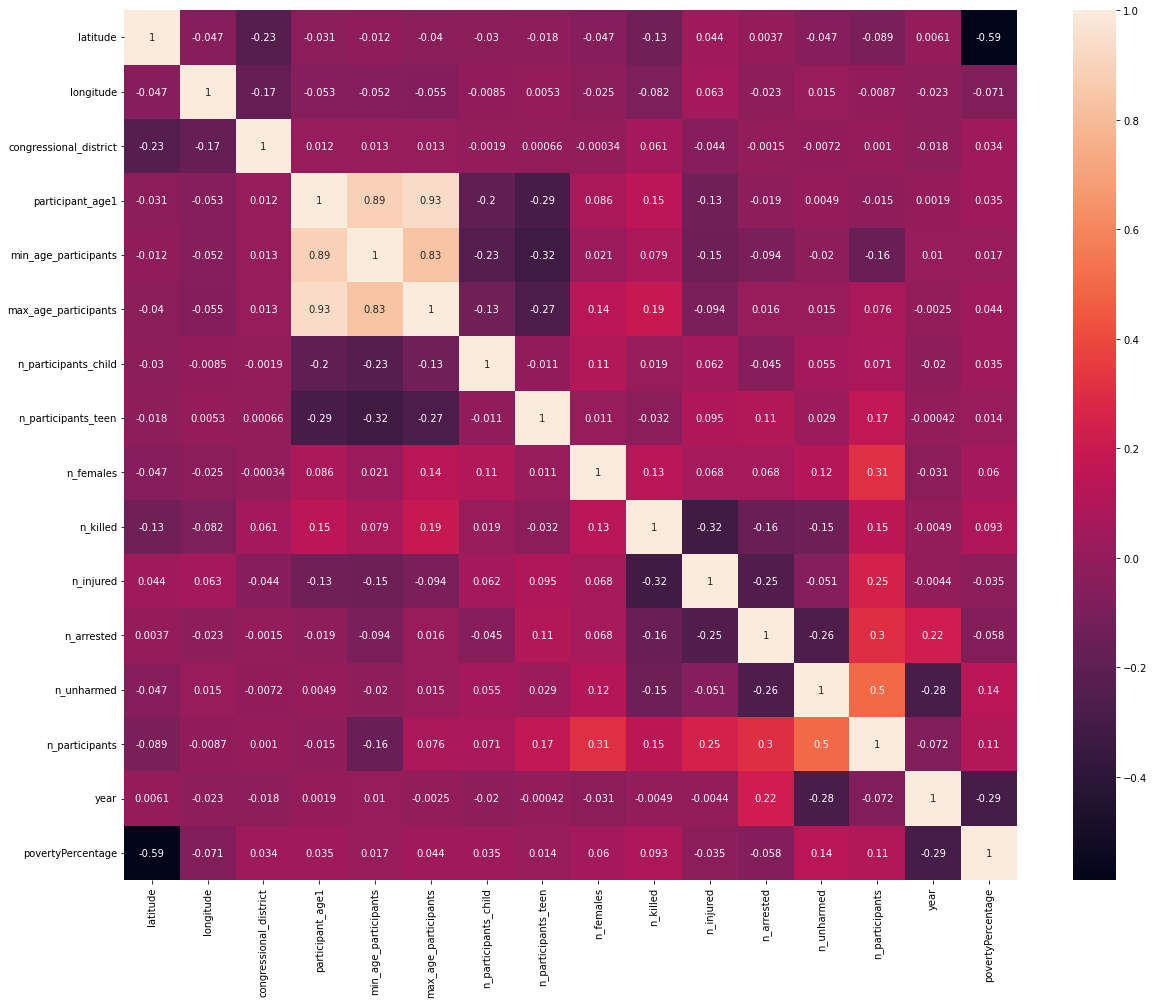

In [9]:


""" 
numerical_features = df_merged.select_dtypes(include=[np.number]).columns

plt.figure(figsize=(20, 16))  # Adjust the values (width, height) as needed
correlation_matrix_all = df_merged[numerical_features].corr()
sns.heatmap(correlation_matrix_all, annot=True) 
 """

def plot_correlation(numerical_features, df):
    plt.figure(figsize=(20, 16))  # Adjust the values (width, height) as needed
    correlation_matrix = df[numerical_features].corr()
    sns.heatmap(correlation_matrix, annot=True) 
    plt.show()
    
plot_correlation(df_merged.select_dtypes(include=[np.number]).columns, df_merged)

### Age and Gender incidents per state

Let's see how incidents are distributed for age and gender on the various states. This can be useful for:

# Incident density per state

Let visualize with the map and the density of incidents per state.

In [10]:
import plotly.graph_objs as go

# density of incident per state

# Densities are n_participants in that state divided by the total number of participants in the dataset
densities = df_merged.groupby('state')['n_participants'].sum()/ df_merged['n_participants'].sum()

# normalize densities using min-max normalization
densities = (densities - densities.min()) / (densities.max() - densities.min())

# order by density
densities = densities.sort_values()

# plot a bar plot

data = [go.Bar(
            x=densities.index, # assign x as the dataframe column 'x'
            y=densities.values
    )]  

py.iplot(data, filename='basic-bar')

# add this as index to the dataframe
df_merged['density_incident_state'] = df_merged['state'].map(densities)


In [11]:
df_merged.head()

date       state  city_or_county  latitude  longitude  \
0 2014-01-01    Arkansas      Pine Bluff   34.2291   -91.9779   
1 2014-01-01  California     Bakersfield   35.3229  -119.0380   
2 2014-01-01        Iowa       Iowa City   41.6611   -91.5302   
3 2014-01-01    New York        Brooklyn   40.6505   -73.9573   
4 2014-01-01    Colorado  Grand Junction   39.0496  -108.5250   

   congressional_district  participant_age1 participant_age_group1  \
0                       4                26              Adult 18+   
1                      23                28              Adult 18+   
2                       2                35              Adult 18+   
3                       9                28              Adult 18+   
4                       3                47              Adult 18+   

  participant_gender1  min_age_participants  max_age_participants  \
0                Male                    26                    26   
1                Male                    28                    28   
2              Female                    35                    35   
3                Male                    28                    30   
4                Male                    47                    47   

   n_participants_child  n_participants_teen  n_females  n_killed  n_injured  \
0                     0                    0          0         0          1   
1                     0                    0          0         0          2   
2                     0                    0          2         0          1   
3                     0                    0          1         0          3   
4                     0                    0          0         1          0   

   n_arrested  n_unharmed  n_participants  \
0           0           1               2   
1           0           0               2   
2           0           1               2   
3           0           0               3   
4           0           0               1   

                   incident_characteristics1  year  povertyPercentage  \
0                     Shot - Wounded/Injured  2014               16.8   
1                     Shot - Wounded/Injured  2014               14.5   
2                                      other  2014               10.1   
3                     Shot - Wounded/Injured  2014               13.4   
4  Shot - Dead (murder, accidental, suicide)  2014               10.2   

  n_killed_per_participant  density_incident_state  
0                No deaths                0.136149  
1                No deaths                0.639968  
2                No deaths                0.096973  
3                No deaths                0.534650  
4               All deaths                0.097775

## Ratio males to females per incident

This can arise some information with the other categorical variables.


In [12]:
# ratio males to females participants in each incident
# in order to get this ratio

df_merged['males_to_females_ratio'] = (df_merged['n_participants']-df_merged['n_females']) / df_merged['n_females'].replace(0, 1)


In [13]:
df_merged.head()

date       state  city_or_county  latitude  longitude  \
0 2014-01-01    Arkansas      Pine Bluff   34.2291   -91.9779   
1 2014-01-01  California     Bakersfield   35.3229  -119.0380   
2 2014-01-01        Iowa       Iowa City   41.6611   -91.5302   
3 2014-01-01    New York        Brooklyn   40.6505   -73.9573   
4 2014-01-01    Colorado  Grand Junction   39.0496  -108.5250   

   congressional_district  participant_age1 participant_age_group1  \
0                       4                26              Adult 18+   
1                      23                28              Adult 18+   
2                       2                35              Adult 18+   
3                       9                28              Adult 18+   
4                       3                47              Adult 18+   

  participant_gender1  min_age_participants  max_age_participants  \
0                Male                    26                    26   
1                Male                    28                    28   
2              Female                    35                    35   
3                Male                    28                    30   
4                Male                    47                    47   

   n_participants_child  n_participants_teen  n_females  n_killed  n_injured  \
0                     0                    0          0         0          1   
1                     0                    0          0         0          2   
2                     0                    0          2         0          1   
3                     0                    0          1         0          3   
4                     0                    0          0         1          0   

   n_arrested  n_unharmed  n_participants  \
0           0           1               2   
1           0           0               2   
2           0           1               2   
3           0           0               3   
4           0           0               1   

                   incident_characteristics1  year  povertyPercentage  \
0                     Shot - Wounded/Injured  2014               16.8   
1                     Shot - Wounded/Injured  2014               14.5   
2                                      other  2014               10.1   
3                     Shot - Wounded/Injured  2014               13.4   
4  Shot - Dead (murder, accidental, suicide)  2014               10.2   

  n_killed_per_participant  density_incident_state  males_to_females_ratio  
0                No deaths                0.136149                     2.0  
1                No deaths                0.639968                     2.0  
2                No deaths                0.096973                     0.0  
3                No deaths                0.534650                     2.0  
4               All deaths                0.097775                     1.0

date                         0
state                        0
city_or_county               0
latitude                     0
longitude                    0
congressional_district       0
participant_age1             0
participant_age_group1       0
participant_gender1          0
min_age_participants         0
max_age_participants         0
n_participants_child         0
n_participants_teen          0
n_females                    0
n_killed                     0
n_injured                    0
n_arrested                   0
n_unharmed                   0
n_participants               0
incident_characteristics1    0
year                         0
povertyPercentage            0
n_killed_per_participant     0
density_incident_state       0
males_to_females_ratio       0
dtype: int64

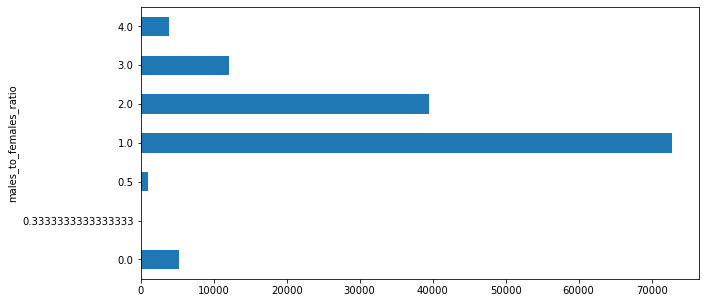

In [14]:
# Group by ratio male females and do barplot

# now the other way around
df_merged.groupby('males_to_females_ratio')['participant_age_group1'].count().plot(kind='barh', figsize=(10, 5), rot=0) 

# We see very few incidents from 0 to 0.5, then a lot at 1, then half than the 1 for the ratio of 2, and so on until 4
# We can say that in half of incidents the ratio is 1 and in the rest more man dies...

df_merged_pca = df_merged.copy()

# Check for nans
df_merged_pca.isnull().sum()

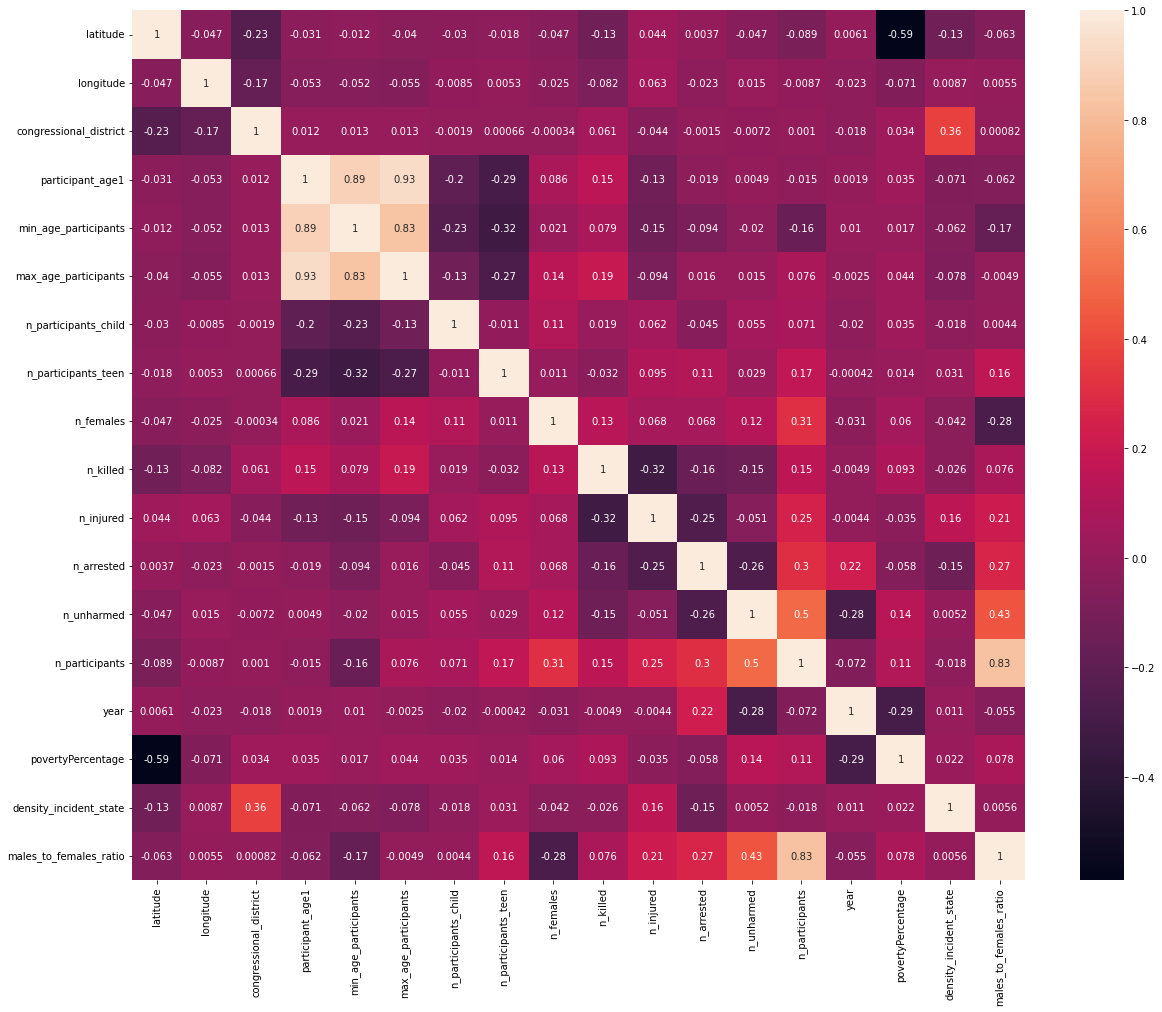

In [15]:

plot_correlation(df_merged.select_dtypes(include=[np.number]).columns, df_merged)

## PCA Analysis

Let's perform a PCA analysis on the new data we have created.


### Pairplot

In [16]:
df_merged.describe()

date       latitude      longitude  \
count                         134579  134579.000000  134579.000000   
mean   2016-03-22 10:28:13.869028096      37.897854     -88.852587   
min              2014-01-01 00:00:00      19.111400    -171.429000   
25%              2015-04-02 00:00:00      34.159000     -92.395950   
50%              2016-04-10 00:00:00      39.065500     -86.224200   
75%              2017-04-05 00:00:00      41.690050     -79.751750   
max              2018-03-31 00:00:00      71.336800     -67.275000   
std                              NaN       5.129033      14.253473   

       congressional_district  participant_age1  min_age_participants  \
count           134579.000000     134579.000000         134579.000000   
mean                 7.657123         30.425676             28.671784   
min                  0.000000          1.000000              1.000000   
25%                  2.000000         21.000000             20.000000   
50%                  5.000000         27.000000             25.000000   
75%                 10.000000         37.000000             34.000000   
max                 53.000000         99.000000             96.000000   
std                  8.136167         13.287022             12.478331   

       max_age_participants  n_participants_child  n_participants_teen  \
count         134579.000000         134579.000000        134579.000000   
mean              31.783822              0.021779             0.132562   
min                1.000000              0.000000             0.000000   
25%               22.000000              0.000000             0.000000   
50%               28.000000              0.000000             0.000000   
75%               38.000000              0.000000             0.000000   
max               99.000000              3.000000             4.000000   
std               13.642167              0.162853             0.415621   

           n_females       n_killed      n_injured     n_arrested  \
count  134579.000000  134579.000000  134579.000000  134579.000000   
mean        0.206548       0.345827       0.479986       0.531606   
min         0.000000       0.000000       0.000000       0.000000   
25%         0.000000       0.000000       0.000000       0.000000   
50%         0.000000       0.000000       0.000000       0.000000   
75%         0.000000       1.000000       1.000000       1.000000   
max         4.000000       3.000000       3.000000       4.000000   
std         0.451941       0.545524       0.627440       0.722694   

          n_unharmed  n_participants           year  povertyPercentage  \
count  134579.000000   134579.000000  134579.000000      134579.000000   
mean        0.364069        1.729728    2015.743013          12.539924   
min         0.000000        1.000000    2014.000000           5.400000   
25%         0.000000        1.000000    2015.000000          10.700000   
50%         0.000000        2.000000    2016.000000          12.200000   
75%         1.000000        2.000000    2017.000000          14.100000   
max         4.000000        4.000000    2018.000000          20.800000   
std         0.714275        0.840858       1.203193           2.756330   

       density_incident_state  males_to_females_ratio  
count           134579.000000           134579.000000  
mean                 0.403271                1.514931  
min                  0.000000                0.000000  
25%                  0.235904                1.000000  
50%                  0.389732                1.000000  
75%                  0.580850                2.000000  
max                  1.000000                4.000000  
std                  0.266234                0.827585

## Before PCA we need to preprocess

In [17]:
""" # Covariance matrix only for numerical features

# Scaler with mean and variance 
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler(with_std=True, with_mean=True)

# Scale features
df_merged_pca[df_merged_pca.select_dtypes(include=[np.number]).columns] = scaler.fit_transform(df_merged_pca[df_merged_pca.select_dtypes(include=[np.number]).columns])


covariance_matrix = df_merged_pca.select_dtypes(include=[np.number]).cov()
covariance_matrix


# eigenvalues and eigenvectors extraction
eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)

# Order by eigenvalues
idx = eigenvalues.argsort()[::-1]
eigenvalues = eigenvalues[idx]
eigenvectors = eigenvectors[:,idx]
 """

' # Covariance matrix only for numerical features\n\n# Scaler with mean and variance \nfrom sklearn.preprocessing import StandardScaler\n\nscaler = StandardScaler(with_std=True, with_mean=True)\n\n# Scale features\ndf_merged_pca[df_merged_pca.select_dtypes(include=[np.number]).columns] = scaler.fit_transform(df_merged_pca[df_merged_pca.select_dtypes(include=[np.number]).columns])\n\n\ncovariance_matrix = df_merged_pca.select_dtypes(include=[np.number]).cov()\ncovariance_matrix\n\n\n# eigenvalues and eigenvectors extraction\neigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)\n\n# Order by eigenvalues\nidx = eigenvalues.argsort()[::-1]\neigenvalues = eigenvalues[idx]\neigenvectors = eigenvectors[:,idx]\n '

## Scree plot

In [18]:
""" # Visualize eigenvalues
plt.figure(figsize=(10, 6))
plt.plot(eigenvalues, marker='o')
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.show()
 """

" # Visualize eigenvalues\nplt.figure(figsize=(10, 6))\nplt.plot(eigenvalues, marker='o')\nplt.xlabel('Principal Component')\nplt.ylabel('Eigenvalue')\nplt.show()\n "

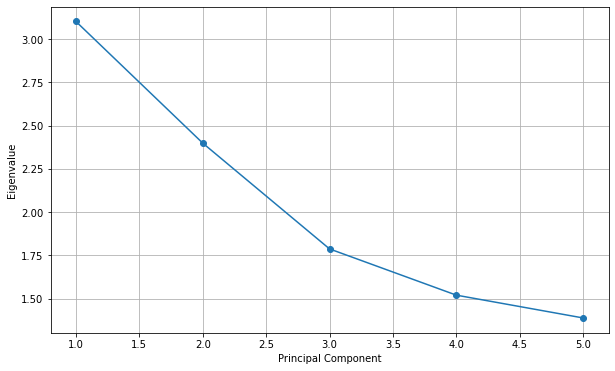

Index(['participant_age_group1', 'participant_gender1',
       'incident_characteristics1', 'n_killed_per_participant'],
      dtype='object')


" \n# project the two more separated components\nplt.figure(figsize=(10, 8))\nplt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_merged_pca['n_killed_per_participant'].cat.codes, cmap='viridis')\nplt.xlabel('First principal component')\nplt.ylabel('Second principal component')\nplt.title('Projection of incidents on the first two principal components')\nplt.show()\n\n "

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_merged_pca.select_dtypes(include=[np.number]))

pca = PCA(n_components=5)
X_pca = pca.fit(X_scaled)

# getting eigenvalues and eigenvectors
eigenvalues = pca.explained_variance_
eigenvectors = pca.components_

explained_variance_ratio = pca.explained_variance_ratio_

# Screeplot
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(eigenvalues)+1), eigenvalues, marker='o')
#add grid
plt.grid()
plt.xlabel('Principal Component')
plt.ylabel('Eigenvalue')
plt.show()


# print categorical columns
print(df_merged_pca.select_dtypes(include=['category']).columns)


""" 
# project the two more separated components
plt.figure(figsize=(10, 8))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_merged_pca['n_killed_per_participant'].cat.codes, cmap='viridis')
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of incidents on the first two principal components')
plt.show()

 """

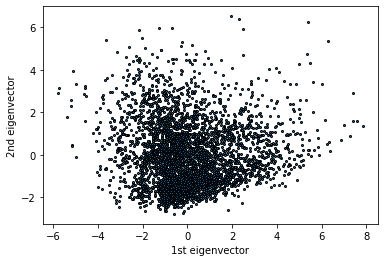

In [62]:
# take first 3 components
pca = PCA(n_components = 2)

principal_components = pca.fit_transform(X_scaled)

# transform original dataframe with the new components
df_merged_pca = pd.DataFrame(principal_components, columns=['PC1', 'PC2'])

len(df_merged_pca)

# sample 4000 incidents
df_merged_pca = df_merged_pca.sample(n=4000, random_state=42)

plt.scatter(df_merged_pca['PC1'], df_merged_pca['PC2'], cmap=plt.cm.Set1, edgecolor='k', s=4)
plt.xlabel("1st eigenvector")
plt.ylabel("2nd eigenvector")
plt.show()

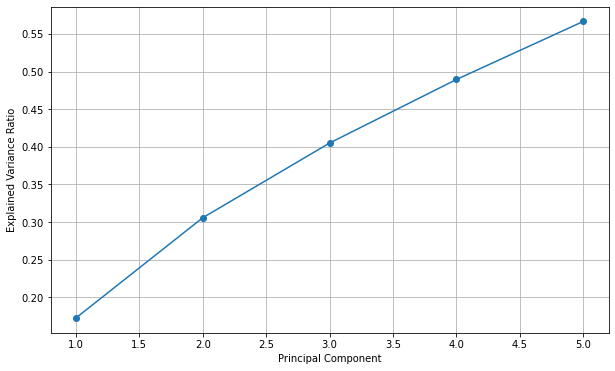

In [39]:
df_merged_pca.head()

# Plots comulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(explained_variance_ratio)+1), np.cumsum(explained_variance_ratio), marker='o')
plt.grid()
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.show()

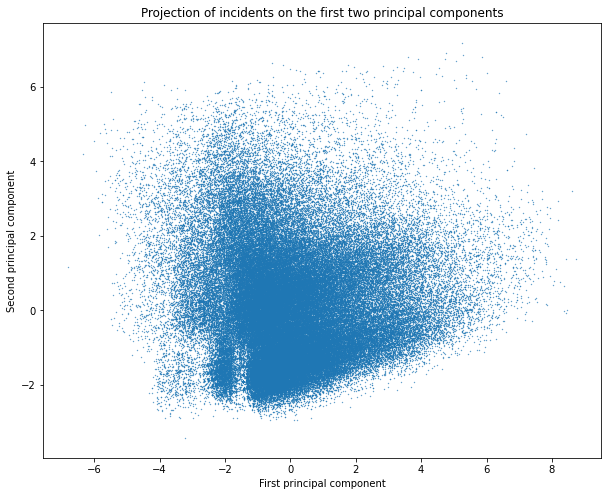

In [47]:
# Scatter plot of the first two components
plt.figure(figsize=(10, 8))
plt.scatter(df_merged_pca['PC1'], df_merged_pca['PC2'], s=0.1)
plt.xlabel('First principal component')
plt.ylabel('Second principal component')
plt.title('Projection of incidents on the first two principal components')
plt.show()

Text(0.5, 1.0, 'Projection of incidents on the second and third principal components')

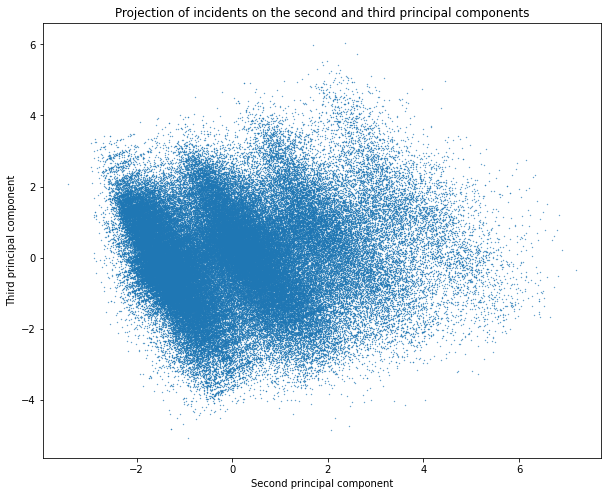

In [45]:
#Scatter plot of second and third components
plt.figure(figsize=(10, 8))
plt.scatter(df_merged_pca['PC2'], df_merged_pca['PC3'], s=0.1)
plt.xlabel('Second principal component')
plt.ylabel('Third principal component')
plt.title('Projection of incidents on the second and third principal components')

/tmp/ipykernel_108789/2357424655.py:8: MatplotlibDeprecationWarning:

Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.



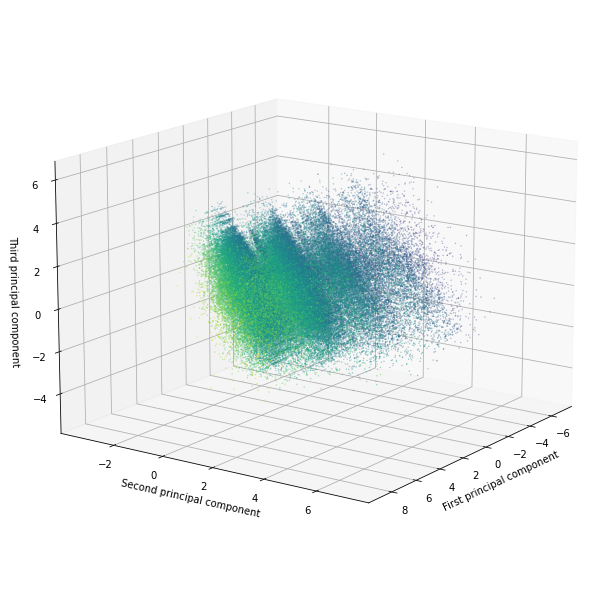

In [60]:
# Overlap three components
from mpl_toolkits.mplot3d import Axes3D
# color each component with different color


fig = plt.figure(figsize=(10, 8))
plt.clf()
ax = Axes3D(fig, rect=[0, 1, .95, 1], elev=15, azim=35)
plt.cla()
ax.scatter(df_merged_pca['PC1'], df_merged_pca['PC2'], df_merged_pca['PC3'], c=df_merged_pca['PC1'], cmap='viridis', s=0.1)
ax.set_xlabel('First principal component')
ax.set_ylabel('Second principal component')
ax.set_zlabel('Third principal component')
plt.show()

# Clustering Analysis


## Geographical Clustering

1. We want to cluster the states based on the number of incidents per state. We will use the K-Means algorithm.
2. We can explore if some regions or states have similar incidents characteristics.

In [20]:
# Before Kmeans let's do some feature engineering

# We want to cluster state based on the number of incidents per state: we can use the density we computed before
# Now let's see the elbow method to see how many clusters we should use


In [21]:
# Import libraries for K-means clustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm



# Select the features we want to use for clustering: States because we want incidents per state
# Let's encode the states with coordinate of our tuples of latitude and longitude

""" The way kmeans algorithm works is as follows:

    Specify number of clusters K.
    Initialize centroids by first shuffling the dataset and then randomly selecting K data points for the centroids without replacement.
    Keep iterating until there is no change to the centroids. i.e assignment of data points to clusters isn’t changing.

    Compute the sum of the squared distance between data points and all centroids.
    Assign each data point to the closest cluster (centroid).
    Compute the centroids for the clusters by taking the average of the all data points that belong to each cluster.
"""
DENSITY_INCIDENT_STATE = False

if DENSITY_INCIDENT_STATE:
    ## KMenas clustering for incident x state using the density of incidents per state
    X = df_merged[['density_incident_state']].values
else:
    # Assuming df is your DataFrame with latitude and longitude columns
    X = df[['latitude', 'longitude']]

# Standardize the features (important for KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# We want to cluster the states based on the number of incidents per state
# We want to find the optimal number of clusters using the elbow method
# We want to use the silhouette score to evaluate the quality of the clusters

# We will try different number of clusters from 2 to 10
n_clusters = np.arange(2, 11)

silhouette_scores = []
inertia_scores = []
kmeans_models = []
elbow_scores = []

# For each number of clusters
for n in tqdm(n_clusters):
    # Initialize the KMeans model with n_clusters=n
    # Use KMenans++ initialization for faster convergence
    kmeans = KMeans(n_clusters=n, random_state=42,
                    n_init=10, max_iter=100, algorithm='lloyd', init='k-means++')

    # Fit the model
    kmeans.fit(X)
    print("Current model:", kmeans)
    
    # Get the inertia score
    inertia_scores.append(kmeans.inertia_)
    print("Current inertia score:", kmeans.inertia_)
    
    # Get the silhouette score
    #silhouette_scores.append(silhouette_score(X, kmeans.labels_))
    #print("Current silhouette score:", silhouette_score(X, kmeans.labels_))
    
    # Store the model
    kmeans_models.append(kmeans)

 11%|█         | 1/9 [00:01<00:11,  1.39s/it]

Current model: KMeans(max_iter=100, n_clusters=2, n_init=10, random_state=42)
Current inertia score: 11222389.347041508


 22%|██▏       | 2/9 [00:02<00:09,  1.33s/it]

Current model: KMeans(max_iter=100, n_clusters=3, n_init=10, random_state=42)
Current inertia score: 6990325.540135369


 33%|███▎      | 3/9 [00:04<00:08,  1.35s/it]

Current model: KMeans(max_iter=100, n_clusters=4, n_init=10, random_state=42)
Current inertia score: 5473323.261583779


 44%|████▍     | 4/9 [00:05<00:06,  1.23s/it]

Current model: KMeans(max_iter=100, n_clusters=5, n_init=10, random_state=42)
Current inertia score: 4118208.04342911


 56%|█████▌    | 5/9 [00:06<00:05,  1.30s/it]

Current model: KMeans(max_iter=100, n_clusters=6, n_init=10, random_state=42)
Current inertia score: 2975584.3687686534


 67%|██████▋   | 6/9 [00:08<00:04,  1.37s/it]

Current model: KMeans(max_iter=100, n_clusters=7, n_init=10, random_state=42)
Current inertia score: 2520798.4762713965


 78%|███████▊  | 7/9 [00:09<00:02,  1.47s/it]

Current model: KMeans(max_iter=100, n_init=10, random_state=42)
Current inertia score: 2237471.7946352423


 89%|████████▉ | 8/9 [00:10<00:01,  1.40s/it]

Current model: KMeans(max_iter=100, n_clusters=9, n_init=10, random_state=42)
Current inertia score: 1989065.7053231124


100%|██████████| 9/9 [00:13<00:00,  1.49s/it]

Current model: KMeans(max_iter=100, n_clusters=10, n_init=10, random_state=42)
Current inertia score: 1688414.0822426314


# Eblow method to get ideal number of clusters

We can see that the ideal number of clusters is 5.

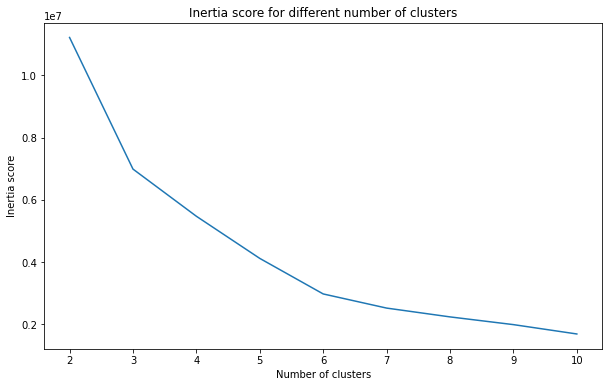

In [22]:
# Plot the inertia score for each number of clusters o
plt.figure(figsize=(10, 6))
plt.plot(n_clusters, inertia_scores)
plt.xlabel('Number of clusters')
plt.ylabel('Inertia score')
plt.title('Inertia score for different number of clusters')
plt.show()




In [23]:

N_CLUSTER_PREDICT = 5

df_clusters = df_merged.copy()

# Add the cluster labels to the dataframe
df_clusters['cluster'] = kmeans_models[N_CLUSTER_PREDICT].labels_

# centroids
centroids = kmeans_models[N_CLUSTER_PREDICT].cluster_centers_


# For logitude and latitude clustering visualization

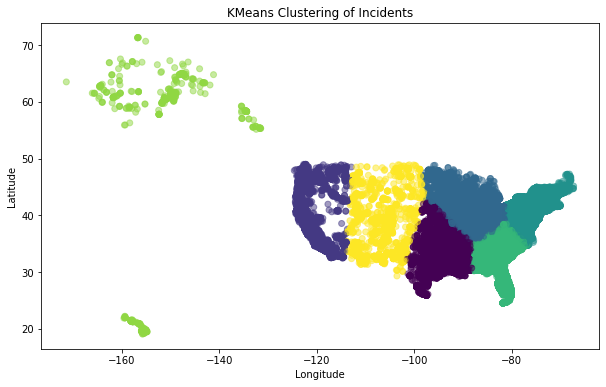

In [24]:
# Visualize the clusters (scatter plot of latitude and longitude with different colors for each cluster)
plt.figure(figsize=(10, 6))

plt.scatter(df_clusters['longitude'], df_clusters['latitude'], c=df_clusters['cluster'], cmap='viridis', alpha=0.5)
plt.title('KMeans Clustering of Incidents')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()



## For density incident state


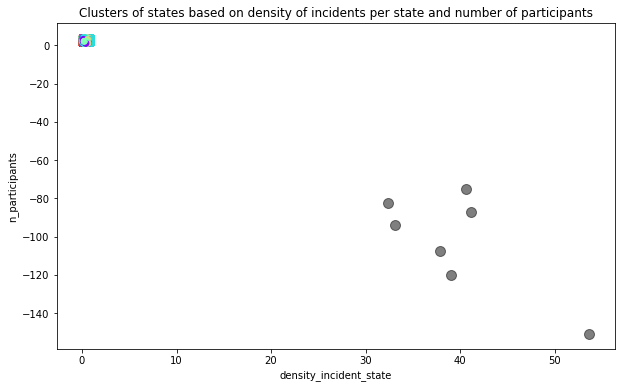

In [25]:

# Not execute this cell if DENSITY_INCIDENT_STATE is False to do it in ipynb use: 


# Visualizing cluster
plt.figure(figsize=(10, 6))

# Plot the clusters
plt.scatter(df_clusters['density_incident_state'], df_clusters['n_participants'], c=df_clusters['cluster'], cmap='rainbow')
# add centroids
plt.scatter(centroids[:, 0], centroids[:, 1], c='black', s=100, alpha=0.5)
plt.xlabel('density_incident_state')
plt.ylabel('n_participants')
plt.title('Clusters of states based on density of incidents per state and number of participants')
plt.show()

